Name : Arun Ranjan Sahu<br>
Regd No.: 22552<br>
Course: I M.Tech (CS)<br>
Paper Code : MTCS-205 (HCI-3 )<br>

### Import Required Libraries

In [ ]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_PATH = "/content/drive/My Drive/HCI3_2023/Images/22552_ ArunRanjanSahu/"

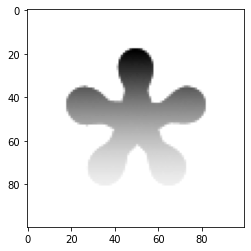

In [ ]:
# Load the image in grayscale 
img = cv2.imread(IMAGE_PATH +'/3.bmp',0)
plt.imshow(img,cmap='gray')

## Step 1 : Initialize the level set function phi, and set the coefficient length penalty term v,time step t, the parameter gamma and other parameters


### Initialize the level set function

In [ ]:
def initialize(img):
    phi = np.ones((img.shape[0],img.shape[1])).astype(img.dtype)
    phi[25:50,25:50]= -1 
    phi=-phi
    return phi

In [ ]:
phi = initialize(img)

(([], []), ([], []))

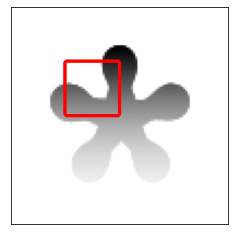

In [ ]:
plt.imshow(img,cmap='gray')
plt.contour(phi,colors = 'red',linestyles = 'solid')
plt.xticks([]), plt.yticks([]) 
# plt.savefig('coins_init.png',bbox_inches='tight')

### Setting up the parameters

In [ ]:
v = 1
time_step = 0.1
gamma = 0.01

## Step 2: Calculate the image local entropy

### Local Entropy
$h_w(P_x(y)) = -\int\limits_0^L P_x(y)log_2P_x(y) dy$ <br>


In [ ]:
# Local entropy in a window
def ent_loc(img,win_i_strt,win_j_strt): 
    temp = img
    p = np.array([(temp[win_i_strt:win_i_strt+9,win_j_strt:win_j_strt+9]==v).sum() for v in range(256)]) #calculate the normalized histogram
    P = p/(p.sum()+0.001) #the probability values
    return -(P[P>0]*np.log2(P[P>0])).sum()

In [ ]:
# Calculate the local entropy and append it to the list
h=[]
for i in range(img.shape[0]-9) :
    for j in range(img.shape[1]-9):
        val_ent = ent_loc(img,i,j)
        h.append(val_ent)

### ***Normalize*** the local entropy in range of `[0,1]`

In [ ]:
# Normalize local entropy
from sklearn.preprocessing import normalize
h_loc= normalize([h],norm ='max')
h_w = h_loc.flatten()

### ***Adaptive Parameters***
$ \alpha = \gamma*(1-h_{mean})*(1-h_w) $<br>
$\beta = 1 - \alpha$

In [ ]:
# Normalize mean Entropy
h_mean = sum(h)/len(h)
rang = np.max(h)-np.min(h)
h_norm = (h_mean - min(h))/rang

## Step 3: Calculate the values of c1, c2, f1, f2


$  c_1 = \frac{\int\limits_{\Omega}I(x)H_{\epsilon}(\phi(x))}{\int\limits_{\Omega}H_{\epsilon}(\phi(x))} dx$<br>
$ c_2 = \frac{\int\limits_{\Omega}I(x)(1-H_{\epsilon}(\phi(x)))}{\int\limits_{\Omega}1-H_{\epsilon}(\phi(x))} dx$ <br>


In [ ]:
def c1c2(img):
    inside_idx = np.flatnonzero(phi >= 0)
    outside_idx = np.flatnonzero(phi < 0)
    #mean value inside curve
    c1 = np.sum(img.flat[inside_idx]) / (len(inside_idx) + 0.00001)  # exterior mean
    #mean value outside curve
    c2 = np.sum(img.flat[outside_idx]) / (len(outside_idx) + 0.00001)  # interior mean
    return c1,c2

In [ ]:
win_rows,win_cols = 19, 19
window = np.ones((win_rows,win_cols))/(win_cols*win_rows)

### Heaviside function
$H(z) = \frac{1}{2}[1+\frac{2}{\pi}arctan(\frac{z}{\epsilon})]$ 

In [ ]:
import itertools
import math
def H_of_phi(img):
    e = 1
    rows = img.shape[0]
    cols = img.shape[1]
    h_of_phi = [[0]*cols]*rows
    h_of_phi = np.array(h_of_phi)
    # for i, j in itertools.product(range(rows), range(cols)):
    for i, j in itertools.product(range(int(rows)), range(int(cols))):
        if phi[i][j]>e:
            h_of_phi[i][j] = 1
        elif phi[i][j]<e:
            h_of_phi[i][j] = 0
        else:
            h_of_phi[i][j]=0.5*(1+(2/np.pi)*(math.atan(phi[i][j]))/e)
    return h_of_phi



$ f_1 = \frac{\int\limits_{\Omega}g_k(x-y)(I(y)H(\phi(y))}{\int\limits_{\Omega}g_k(x-y)H((\phi(y)))} dx$<br>

In [ ]:
def f1(img,window):
    hofphi = H_of_phi(img)
    prod_num = (img*hofphi)
    numerator_f1 = cv2.filter2D(prod_num,-1,window)
    denominator_f1 = cv2.filter2D(hofphi,-1,window)
    return np.sum(numerator_f1/(denominator_f1+1))

f_1 = f1(img,window)
f_1

1152665.0


$f_2 = \frac{\int\limits_{\Omega}g_k(x-y)(I(y)(1-H(\phi(y)))}{\int\limits_{\Omega}g_k(x-y)(1-H((\phi(y))))} dx$<br>

In [ ]:
def f2(img,window):
    hofphi = H_of_phi(img)
    prod_num = (img*(1-hofphi))
    numerator_f1 = cv2.filter2D(prod_num,-1,window)
    denominator_f1 = cv2.filter2D((1-hofphi),-1,window)
    return np.sum(numerator_f1/(denominator_f1+1))

f_2 = f2(img,window)
f_2

84341.0

## Step 4: Evolve the level set function according to formula(17), then regularize the level set function by equation(18)

### ***Dirac Function***
$\delta_{\epsilon}(z)  = \frac{1}{\pi} \frac{\epsilon}{\epsilon^2+z^2}$

In [ ]:
def delta(phi):
    e = 1
    rows = phi.shape[0]
    cols = phi.shape[1]
    delta_phi = [[0]*cols]*rows
    delta_phi = np.array(delta_phi)
    return ((1/np.pi)*(e/(e**2+delta_phi**2)))

In [ ]:
# Calculate the gradient
def gradient(f):		
    fx = f
    fy = f
    n, m = f.shape
    fx[:, 0] = f[:, 1] - f[:, 0]
    fx[:, -1] = f[:, -1] - f[:, -2]
    fy[0, :] = f[1,:] - f[0,:]
    fy[-1, :] = f[-1,:] - f[-2,:]
    for j in range(1, m-1):
        fx[:, j] = (f[:, j+1] - f[:, j-1]) / 2.0
    for i in range(1, n-1):
        fy[i, :] = (f[i+1, :] - f[i-1, :]) / 2.0
    return fx, fy


In [ ]:
# Calculate the Lenght term
def curvature_central(phi):
    #gradient of phi 
    phi_x, phi_y = gradient(phi)
   
    #Norm of phi
    norm_gradient = np.sqrt(phi_x ** 2 + phi_y ** 2 + 1e-10)

    #return the divergence
    nxx, _ = gradient(phi_x / norm_gradient)
    _, nyy = gradient(phi_y / norm_gradient)
    return (nxx+nyy)


### ***Evolution of level Set***
$ \frac{\partial\phi}{\partial t} = \delta_{\epsilon}(\phi)[\alpha((I-c_2)^2-(I-c_1)^2) + \beta((h_x (I-f_2)^2) - h_x(I-f_1)^2) + \nu*\delta_{\epsilon}(\phi)div(\frac{\Delta\phi}{|\Delta\phi|})]$ <br>

### ***Regularization of the level Set***
$\phi^{n+1} = g_{\sqrt{\Delta t}}\phi^n $

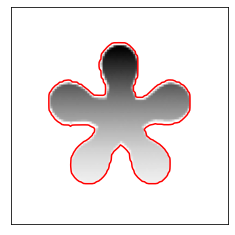

In [ ]:
max_iter = 30
i=0
root_time_step = (time_step)**0.5

for _ in range(max_iter):
    delta_term = delta(phi)
    length_term = curvature_central(phi)

    alpha = gamma*(1-h_w[i])*(1-h_norm) #Parameter for global term
    beta = 1-alpha    #Parameter for Local term

    c1,c2 = c1c2(img)
    f_1 = f1(img,window)
    f_2 = f2(img,window)

    length_term = v*length_term*delta_term
    global_term = alpha*((img-c2)**2 - (img-c1)**2)
    local_term = beta*(h[i]*(img-f_2)**2 - beta*h[i]*(img-f_1)**2)
    partial_phi = delta_term*(length_term + global_term + local_term)

    phi = time_step*partial_phi
    kernel = cv2.getGaussianKernel(5,root_time_step+0.5)
    phi = cv2.filter2D(phi,-1,kernel)
    i+=100

plt.imshow(img,cmap='gray')
plt.xticks([]),plt.yticks([])
plt.contour(phi,0,colors= 'red',linestyles='solid')
